In [2]:
import numpy as np
import scipy
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
import sys
import time
from sklearn.model_selection import train_test_split
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from numpy import pi,exp
from math import exp
from matplotlib.legend import Legend
import datetime
import os

## for plots
plt.rcParams.update({'font.size': 15})

# Format the date as a string to use in the figure name
now = datetime.datetime.now()
datestr = now.strftime("%Y-%m-%d")
#-------------------------------------------------------------------------------

#prepare the entropy set
folder = "../lattice_data/"
data_file = folder + "mu_0_WB-EoS.dat"
data = np.loadtxt(data_file,skiprows=1,max_rows=100,usecols=(0,7,8),unpack=True) #DATA FOR muB=0
Tentr = 0.001*data[0] #in GeV
s_T3 = data[1]
Ds_T3 = data[2]

data = np.loadtxt(data_file,skiprows=1,max_rows=100,usecols=(1,2,3,4,5,6,9,10),unpack=True) #DATA FOR muB=0
I_T4 = data[0]
DI_T4 = data[1]
P_T4 = data[2]
DP_T4 = data[3]
e_T4 = data[4]
De_T4 = data[5]
csdata = data[6]
Dcs = data[7]


#prepare the chiS
# data_file = folder + "thermo_k4.dat"
# data = np.loadtxt(data_file,skiprows=26,max_rows=91,usecols=(0,1,2,3,4,5,6,7,8,9,12,13),unpack=True) #DATA FOR muB=0
# muB_T = data[0]
# TchiS = 0.001*data[1] #in GeV
# chiS = data[10]
# DchiS = data[11]
######## new data 2202.05574v1
data_file = folder + "eos_chis_22.dat"
data = np.loadtxt(data_file,skiprows=1,usecols=(0,1,12,13),unpack=True) #DATA FOR muB=0
muB_T = data[0]
TchiS = 0.001*data[1] #in GeV
chiS = data[2]
DchiS = data[3]
datanew = folder + "chi2_table_1112.txt"
data = np.loadtxt(datanew,skiprows=1,usecols=(0,7,8,9,10),unpack=True) #muB=0 same temperature range
Tnew = 0.001*data[0]
selection = (Tnew > np.max(TchiS))
Tchis_ = Tnew[selection]
chis_ = data[1]
chis_ = chis_[selection]
Dchis_ = data[2]
Dchis_ = Dchis_[selection]
TchiS = np.concatenate((TchiS,Tchis_))
chiS = np.concatenate((chiS,chis_))
DchiS = np.concatenate((DchiS,Dchis_))


#prepare the chib set
data_file = folder + "chiB2.dat"
data_chib = np.loadtxt(data_file,skiprows=5,max_rows=100,usecols=(0,1,2),unpack=True) #muB=0 same temperature range
TchiB = 0.001*data_chib[0]
chiB = data_chib[1]
DchiB = data_chib[2]


#TEMPERATURE CUTS MUST BE CHOSED ACCORDING TO THE TABLE USED TO TRAIN THE SURROGATE. FOR T<T_min, WHERE T_min IS THE MINIMUM VALUE OF T IN THE TABLE, THE SURROGATE IS NOT RELIABLE!
#(THE SAME APPLIES FOR T>T_max)
T_min = 0.155
test_size = 0.2

def split_data(T, Data, error, test_size, T_min):
  #splits the data in training and validation samples in a temperature interval T>T_min
    temperature_cut = (T > T_min)[:len(Data)]
    data_and_errors = np.stack((Data[temperature_cut], error[temperature_cut]),axis=1)
    training_T, validation_T, D_train, D_val = train_test_split(T[temperature_cut], data_and_errors, test_size=test_size)

    training_T = tf.constant(training_T, dtype=tf.float32)
    validation_T = tf.constant(validation_T, dtype=tf.float32)
    D_train = tf.constant(D_train, dtype=tf.float32)
    D_val = tf.constant(D_val, dtype=tf.float32)

    return training_T, validation_T, D_train, D_val


training_Temp_entr, validation_Temp_entr, entr_train, entr_val = split_data(Tentr,s_T3,  Ds_T3, test_size, T_min)
training_Temp_chiS, validation_Temp_chiS, chiS_train, chiS_val = split_data(TchiS, chiS, DchiS, test_size, T_min)
training_Temp_chib, validation_Temp_chib, chib_train, chib_val = split_data(TchiB, chiB, DchiB, test_size, T_min)

### There are two surrogates, one for integrals involved in the entropy and one for those of the susceptibilities. surrogate_entropy[0] and [1] are Ib and If respectively and
### surrogate_chiq is used for the susceptibilities. As input they expect [T,moT,woT] i.e. Temperature, mass/Temperature and width/Temperature
###
surrogate_entropy_loaded = tf.keras.models.load_model('../surrogate_entropy_math.h5') #THE SURROGATES *ONLY* EVALUATE THE INTEGRALS IN THE FORMULAE
surrogate_chiq_loaded = tf.keras.models.load_model('../surrogate_chi_math.h5')


#The surrogate has been trained on normalized data! These values must be used to put it back to the real range of values
max_Ib = 0.183902
max_If = 0.132398
max_chi = 0.133045

#DEGENERACY FACTORS
dg = 16 #gluon
dq = 6 #quark

In [3]:
def dmg_dT(T):
  dT = 0.001
  T1 = tf.constant([T+dT],dtype=tf.float32)
  T0 = tf.constant([T],dtype=tf.float32)

  dmg = (gluon(T1).numpy()*(T+dT)-gluon(T0).numpy()*(T))/dT

  return dmg

def dml_dT(T):
  dT = 0.001
  muoT1 = tf.constant([T+dT],dtype=tf.float32)
  muoT0 = tf.constant([T],dtype=tf.float32)

  dml = (light(muoT1).numpy()*(T+dT)-light(muoT0).numpy()*(T))/dT

  return dml

def dms_dT(T):
  dT = 0.001
  muoT1 = tf.constant([T+dT],dtype=tf.float32)
  muoT0 = tf.constant([T],dtype=tf.float32)

  dms = (strange(muoT1).numpy()*(T+dT)-strange(muoT0).numpy()*(T))/dT

  return dms


##from Kubo
def dfa(fi,E,T,mu):
      sign = np.sign(fi)
      if (fi == 10):
            dfa=1/(np.exp(E/T)-1)  # Bose-Einstein
      else:
        dfa = 1/(np.exp((E-sign*mu)/T)+1)  # Fermi-Dirac
      return dfa


###  spectral function
def rhorel(om,p,m,gam):
    p0 = np.sqrt(p**2+m**2-gam**2)
    rho = gam/p0*(1./((om-p0)**2+gam**2)-1./((om+p0)**2+gam**2))

    return rho
###
def fetaq(om,p,T,ml,ms,m,gaml,gams,gam):
    Nc= 3
    mu = 0
    angular_pref = 1/(30*T)
    ps = 7*om**4-10*om**2*p**2+7*p**4
    fq = 2*rhorel(om,p,ml,gaml)**2 + rhorel(om,p,ms,gams)**2# 2=u+d + s
    ffblock = 2*2*Nc*(dfa(+1,om,T,mu)*(1 - dfa(+1,om,T,mu)))
    etaq = angular_pref*p**2*(1/(2*pi**3)*16/(np.exp(om/(2*T))-np.exp(-om/(2*T)))**2*rhorel(om,p,m,gam)**2*ps + 1/(2*pi**3)*p**4*ffblock*fq)
    return etaq

##conductivity for one specie
def fcond_q(om,p,T,m,gam):
    pref = 1/(4*pi**3)
    qq = 4*pi/137
    Nc= 3
    mu = 0
    ffblock = 2*Nc*(dfa(+1,om,T,mu)*(1 - dfa(+1,om,T,mu))+ dfa(-1,om,T,mu)*(1.-dfa(-1,om,T,mu)))
    sigm = pref*qq*ffblock*(p**2*om**2)*rhorel(om,p,m,gam)**2
    return sigm

##eta over s
def eta_s(T):
  muoT = tf.constant([T],dtype=tf.float32)

  mass_gluon = gluon(muoT)[0].numpy()*T
  mass_light = light(muoT)[0].numpy()*T
  mass_strange = strange(muoT)[0].numpy()*T

  width_gluon = width_g(muoT)[0].numpy()*T
  width_light = width_q(muoT)[0].numpy()*T
  width_strange = width_s(muoT)[0].numpy()*T


  eta =scipy.integrate.dblquad(fetaq, 0, np.inf, 0, np.inf, args = (T, mass_light,mass_strange,mass_gluon ,width_light,width_strange,width_gluon))
  eta_s = eta[0]/s_(T)

  # print(eta_s, " ",eta[1]/s(T))

  return eta_s

def fcond_full(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)
  ml = light(muoT)[0].numpy()*T
  ms = strange(muoT)[0].numpy()*T
  gamq = width_q(muoT)[0].numpy()*T
  gams = width_s(muoT)[0].numpy()*T
  cond_light = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ml ,gamq))
  cond_s = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ms ,gams))
  cond_full = (5/9*cond_light[0] + 1/9*cond_s[0])/(3*T) ## factors 5/9 -refers to u+d ,1/9 - q^2
##full conductivity - summ (u+d) and s quarks contribution
  return cond_full/T

def fcond_light(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)

  ml = light(muoT)[0].numpy()*T
  gamq = width_q(muoT)[0].numpy()*T

  cond_light = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ml ,gamq))
  cond_full = 5/9*cond_light[0]/(3*T) ## factors 5/9 -refers to el charge u+d
##full conductivity - summ (u+d) and s quarks contribution
  return cond_full/T

def fcond_strange(T):
  a = 0
  b = np.inf
  muoT = tf.constant([T],dtype=tf.float32)
  ms = strange(muoT)[0].numpy()*T
  gams = width_s(muoT)[0].numpy()*T
  cond_s = scipy.integrate.dblquad(fcond_q, a, b, a, b, args = (T, ms ,gams))
  cond_full = 1/9*cond_s[0]/(3*T) #1/9 - el charge s-quark

  return cond_full/T


## Olga's fit of the data ->
def chi2B_WB(Temp):
    t = Temp/0.2
    h3 = -0.5
    h4 = 0.6420
    f3 = 0.1420
    f4 = 7.0789
    f5 = -5.32284
    chi2 = tf.math.exp(-h3/t - h4/t**2)*f3*(tf.math.tanh(f4*t + f5) + 1.)
    return chi2

def chi2S_WB(Temp):
    t = Temp/0.2
    h3 = 0.75
    h4 = -0.2810
    f3 = 0.6173
    f4 = 4.8306
    f5 = -4.0393
    chi2s = tf.math.exp(-h3/t - h4/t**2)*f3*(tf.math.tanh(f4*t + f5) + 1.)
    return chi2s

In [22]:
def g_nn(temp_muoT):
  g = quasiparticle(temp_muoT)[:,2]
  return g


def gluon(temp_muoT):
  mg_T = quasiparticle(temp_muoT)[:,0]*g_nn(temp_muoT)
  return mg_T

def ag(temp_muoT):
  ag = quasiparticle(temp_muoT)[:,0]
  return ag

def aq(temp_muoT):
  aq = quasiparticle(temp_muoT)[:,1]
  return aq

def light(temp_muoT):
  ml_T = quasiparticle(temp_muoT)[:,1]*g_nn(temp_muoT)
  return ml_T


def strange(temp_muoT):
  dms =0.15
  ms_T = light(temp_muoT)+dms/temp_muoT
  return ms_T


def width_g(temp_muoT):
  wg_T = quasiparticle(temp_muoT)[:,3]
  return wg_T


def width_q(temp_muoT):
  wq_T = quasiparticle(temp_muoT)[:,4]
  return wq_T


def width_s(temp_muoT):
  ws_T = quasiparticle(temp_muoT)[:,5]
  return ws_T


def entropy_T3(temp_muoT):
  mg_T = gluon(temp_muoT)
  ml_T = light(temp_muoT)
  ms_T = strange(temp_muoT)
  wg_T = width_g(temp_muoT)
  wq_T = width_q(temp_muoT)
  ws_T = width_s(temp_muoT)

  gluons_ = tf.stack([temp_muoT,mg_T,wg_T],axis=1)
  lightq_ = tf.stack([temp_muoT,ml_T,wq_T],axis=1)
  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  Ib = max_Ib*surrogate_entropy_loaded(gluons_)[:,0]
  IfL = max_If*surrogate_entropy_loaded(lightq_)[:,1]
  IfS = max_If*surrogate_entropy_loaded(strangeq_)[:,1]

  entropy_ = dg*Ib+2*(2*dq*IfL+dq*IfS) #the 2 in front of IfL is to count up and down separately

  return entropy_/temp_muoT**3


def chib_T2(temp_muoT):
  ml_T = light(temp_muoT)
  ms_T = strange(temp_muoT)
  wq_T = width_q(temp_muoT)
  ws_T = width_s(temp_muoT)

  lightq_ = tf.stack([temp_muoT,ml_T,wq_T],axis=1)
  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  chib_light = max_chi*surrogate_chiq_loaded(lightq_)[:,0]
  chib_strange = max_chi*surrogate_chiq_loaded(strangeq_)[:,0]
  chioT2 = (2*dq* chib_light + dq* chib_strange)/9 #the 2 in front of IfL is to count up and down separately

  return chioT2/temp_muoT**2


def chis_T2(temp_muoT):
  ms_T = strange(temp_muoT)
  ws_T = width_s(temp_muoT)

  strangeq_ = tf.stack([temp_muoT,ms_T,ws_T],axis=1)

  chis_strange = max_chi*surrogate_chiq_loaded(strangeq_)[:,0]
  chiS = dq*chis_strange

  return chiS/temp_muoT**2


['./setupA_dms0.15_12k/seed_8404_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_8212_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-5176_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-5303_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-8415_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-6588_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-3318_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-9161_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_8946_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-5822_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_9865_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_5705_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_-6132_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_dms0.15_12k/seed_2122_bentr_100_b_chis_1_b_dqpm_1000.0.h5', './setupA_d

<Figure size 640x480 with 0 Axes>

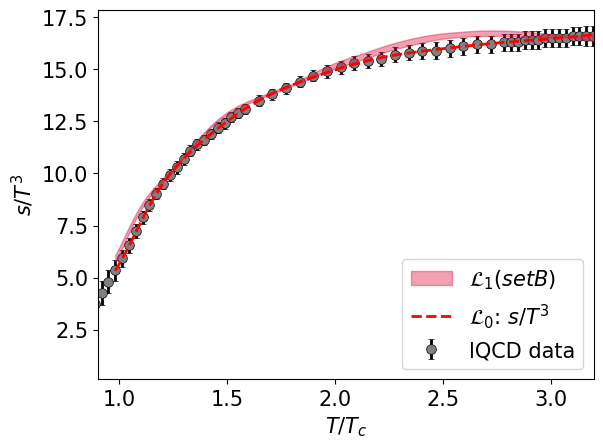

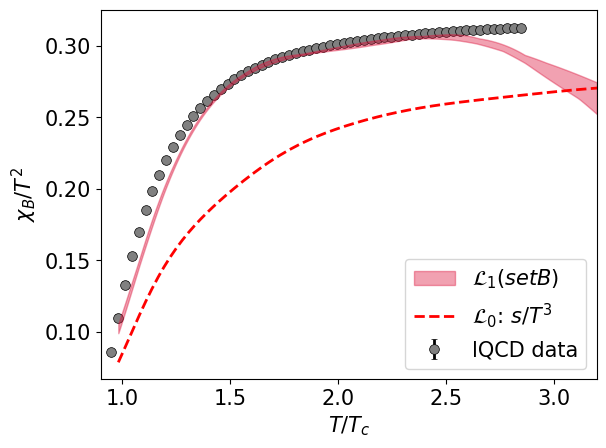

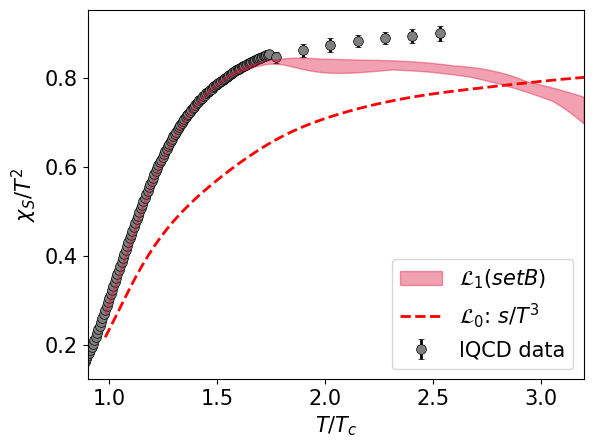

In [23]:
x_size = 200
Tc=0.158
Tmax = 3.2
Temp_values = np.linspace(0.155, Tc*Tmax, x_size)
Temp_tensor = tf.constant(Temp_values, dtype=tf.float32)
#####################comparison
data_l0 = np.loadtxt('..//loss-0-aug/thermo_data_dqpmloss0_dms0.03_entr.txt')

xT_0 = data_l0[::,0]
entr_0 = data_l0[::,1]
chib_0 = data_l0[::,2]
chis_0 = data_l0[::,3]

label_l1 = "$\mathcal{L}_1(setB)$"

dir_seeds = "./setupA_dms0.15_12k/"
files = os.listdir(dir_seeds)
models = [dir_seeds+i for i in files if ".h5" in i]
print(models)
print(np.size(models))

custom_activation = tf.keras.layers.Lambda(lambda x: tf.square(x), name='custom_activation_square')

entr_max = np.zeros(x_size)
chib_max = np.zeros(x_size)
chis_max = np.zeros(x_size)
entr_min = 1e8*np.ones(x_size)
chib_min = 1e8*np.ones(x_size)
chis_min = 1e8*np.ones(x_size)


for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  entropy_fit = entropy_T3(Temp_tensor)
  chibT2_fit = chib_T2(Temp_tensor)
  chisT2_fit = chis_T2(Temp_tensor)

  entr_max = np.max([entr_max,entropy_fit], axis=0)
  chib_max = np.max([chib_max,chibT2_fit], axis=0)
  chis_max = np.max([chis_max,chisT2_fit], axis=0)

  entr_min = np.min([entr_min,entropy_fit], axis=0)
  chib_min = np.min([chib_min,chibT2_fit], axis=0)
  chis_min = np.min([chis_min,chisT2_fit], axis=0)


####################################################################
plt.figure("1")
plt.errorbar(Tentr/Tc,s_T3,yerr=Ds_T3, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.fill_between(Temp_values/Tc, entr_max, entr_min, color="crimson", alpha=0.4,label=label_l1)
plt.plot(xT_0 , entr_0, '--', color='red', label=r'$\mathcal{L}_0$: $s/T^3$', linewidth=2)
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$s/T^3$")
plt.xlim([0.9, Tmax])
plt.legend()
####################################################################
plt.figure("2")
plt.errorbar(TchiB/Tc, chiB,yerr=DchiB, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.fill_between(Temp_values/Tc, chib_max, chib_min, color="crimson", alpha=0.4,label=label_l1)
plt.plot(xT_0 , chib_0, '--', color='red', label=r'$\mathcal{L}_0$: $s/T^3$', linewidth=2)
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$\chi_B/T^2$")
plt.xlim([0.9, Tmax])
plt.legend()
####################################################################
plt.figure("3")
plt.errorbar(TchiS/Tc, chiS, yerr=DchiS, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.fill_between(Temp_values/Tc, chis_max, chis_min, color="crimson", alpha=0.4,label=label_l1)
plt.plot(xT_0 , chis_0, '--', color='red', label=r'$\mathcal{L}_0$: $s/T^3$', linewidth=2)
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$\chi_S/T^2$")
plt.xlim([0.9, Tmax])
plt.legend()
####################################################################

data_to_save = np.column_stack((Temp_values/Tc, entr_max, entr_min, chib_max, chib_min, chis_max, chis_min ))
header = 'T/Tc, entr_max, entr_min, chib_max, chib_min, chis_max, chis_min'
namefile = f'cset_eos_3.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f %12.5f %12.5f %12.5f %12.5f', header=header)


plt.show()

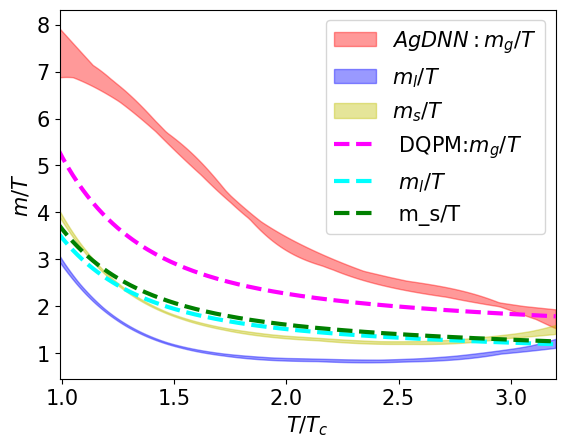

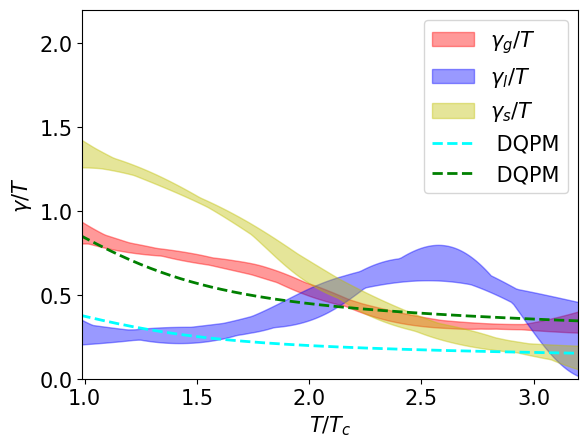

In [24]:
#########parameters##########
Tc=0.158
Tmax = 3.2
#############################
eval = np.linspace(0.155,Tc*Tmax,200)
teval = tf.convert_to_tensor(eval, dtype=tf.float32)

massG_max = np.zeros(x_size)
massL_max = np.zeros(x_size)
massS_max = np.zeros(x_size)
massG_min = 1e8*np.ones(x_size)
massL_min = 1e8*np.ones(x_size)
massS_min = 1e8*np.ones(x_size)

widthG_max = np.zeros(x_size)
widthL_max = np.zeros(x_size)
widthS_max = np.zeros(x_size)
widthG_min = 1e8*np.ones(x_size)
widthL_min = 1e8*np.ones(x_size)
widthS_min = 1e8*np.ones(x_size)


for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  massG = gluon(teval)
  massL = light(teval)
  massS = strange(teval)
  widthG = width_g(teval)
  widthL = width_q(teval)
  widthS = width_s(teval)

  massG_max = np.max([massG_max,massG], axis=0)
  massL_max = np.max([massL_max,massL], axis=0)
  massS_max = np.max([massS_max,massS], axis=0)
  massG_min = np.min([massG_min,massG], axis=0)
  massL_min = np.min([massL_min,massL], axis=0)
  massS_min = np.min([massS_min,massS], axis=0)

  widthG_max = np.max([widthG_max,widthG], axis=0)
  widthL_max = np.max([widthL_max,widthL], axis=0)
  widthS_max = np.max([widthS_max,widthS], axis=0)
  widthG_min = np.min([widthG_min,widthG], axis=0)
  widthL_min = np.min([widthL_min,widthL], axis=0)
  widthS_min = np.min([widthS_min,widthS], axis=0)


#########comparison##########

xT = eval
g2_DQPM = 4*pi*(0.00602 + 0.22908/xT - 0.0425/xT**2 + 0.00288/xT**3  + 0.00148/xT**4)
T_c=0.158
wg_DQPM = g2_DQPM/(8*np.pi)*np.log(2*14.4/g2_DQPM +1)
mg_DQPM = np.sqrt(g2_DQPM*(3/4))
ms_DQPM = np.sqrt(g2_DQPM/3) +0.03/xT
mq_DQPM = np.sqrt(g2_DQPM/3)
#############################

plt.figure('1')
plt.fill_between(eval/Tc,massG_max,massG_min,color='r',label=r'$Ag DNN: m_g/T$', alpha=0.4)
plt.fill_between(eval/Tc,massL_max,massL_min,color='b',label=r'$m_l/T$',alpha=0.4)
plt.fill_between(eval/Tc,massS_max,massS_min,color='y',label=r'$m_s/T$',alpha=0.4)

plt.plot(eval/Tc, mg_DQPM, '--', color = 'magenta',label = ' DQPM:$m_g/T$',linewidth=3)
plt.plot(eval/Tc, mq_DQPM, '--', color = 'cyan',label = ' $m_l/T$',linewidth=3)
plt.plot(eval/Tc, ms_DQPM, '--', color = 'green',label = ' m_s/T',linewidth=3)
#plt.xlabel(r'$T[GeV]$')
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$m/T$')
# plt.ylim([0,9.4])
plt.xlim(0.99,Tmax)
plt.legend()
# plt.savefig(f'./pics/seed{seed}{datestr}_massT_eta{eta}.pdf')


plt.figure('2')
plt.fill_between(eval/Tc,widthG_max,widthG_min,color='r',label=r'$\gamma_g/T$',alpha=0.4)
plt.fill_between(eval/Tc,widthL_max,widthL_min,color='b',label=r'$\gamma_l/T$',alpha=0.4)
plt.fill_between(eval/Tc,widthS_max,widthS_min,color='y',label=r'$\gamma_s/T$',alpha=0.4)

plt.plot(eval/Tc,4/9*wg_DQPM, '--',linewidth =2, color = 'cyan',label = ' DQPM')
plt.plot(eval/Tc, wg_DQPM, '--',linewidth =2, color = 'green',label = ' DQPM')
plt.xlabel(r'$T[GeV]$')
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\gamma/T$')
plt.ylim([0,2.2])
plt.xlim(0.99,Tmax)
plt.legend()
#plt.savefig(f'./pics/seed{seed}{datestr}_coupl_widthT_eta{eta}.pdf')

plt.show()

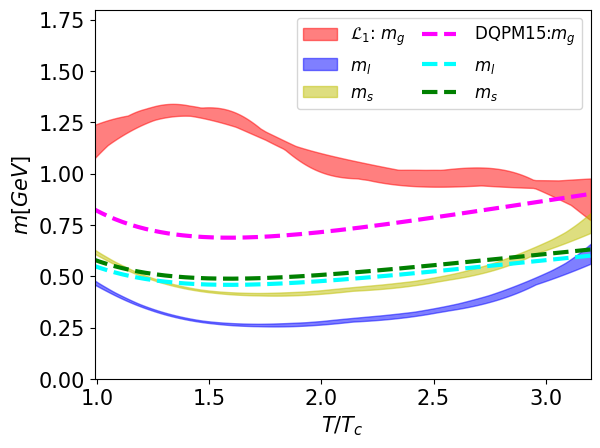

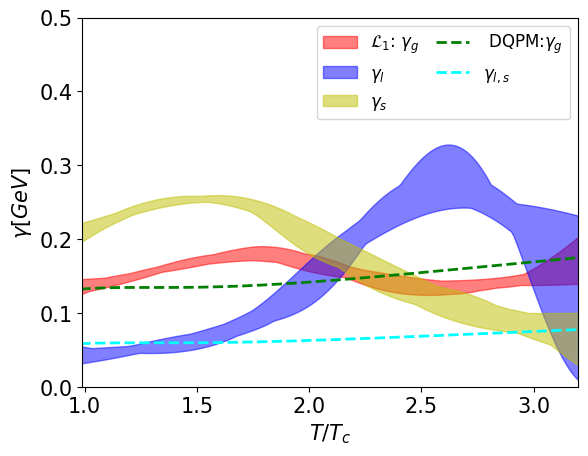

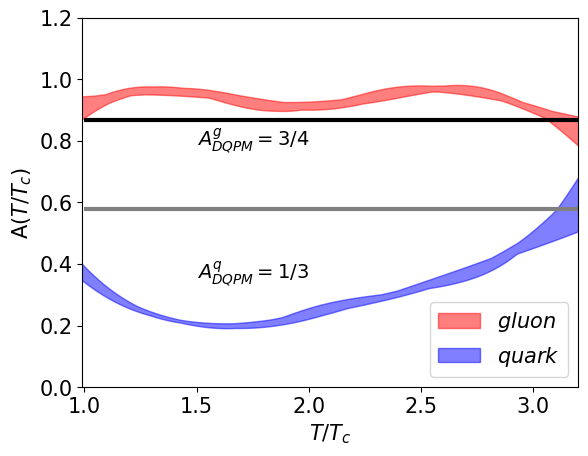

In [25]:
#########parameters##########
Tc=0.158
Tmax = 3.2
x_size = 200
#############################
label_l1 = "$\mathcal{L}_1$ "

eval = np.linspace(0.155,Tc*Tmax,200)
teval = tf.convert_to_tensor(eval, dtype=tf.float32)

massG_max, massL_max, massS_max = np.zeros(x_size), np.zeros(x_size), np.zeros(x_size)
massG_min, massL_min, massS_min = 1e8 * np.ones(x_size), 1e8 * np.ones(x_size), 1e8 * np.ones(x_size)
widthG_max, widthL_max, widthS_max= np.zeros(x_size), np.zeros(x_size), np.zeros(x_size)
widthG_min, widthL_min, widthS_min = 1e8 * np.ones(x_size), 1e8 * np.ones(x_size), 1e8 * np.ones(x_size)
Ag_max, Aq_max = np.zeros(x_size), np.zeros(x_size)
Ag_min, Aq_min = 1e8 * np.ones(x_size), 1e8 * np.ones(x_size)


for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  massG = gluon(teval)
  massL = light(teval)
  massS = strange(teval)
  widthG = width_g(teval)
  widthL = width_q(teval)
  widthS = width_s(teval)
  Ag = ag(teval)
  Aq = aq(teval)

  massG_max = np.max([massG_max,massG], axis=0)
  massL_max = np.max([massL_max,massL], axis=0)
  massS_max = np.max([massS_max,massS], axis=0)
  massG_min = np.min([massG_min,massG], axis=0)
  massL_min = np.min([massL_min,massL], axis=0)
  massS_min = np.min([massS_min,massS], axis=0)

  Ag_max = np.max([Ag_max,Ag], axis=0)
  Aq_max = np.max([Aq_max,Aq], axis=0)

  Ag_min = np.min([Ag_min,Ag], axis=0)
  Aq_min = np.min([Aq_min,Aq], axis=0)

  widthG_max = np.max([widthG_max,widthG], axis=0)
  widthL_max = np.max([widthL_max,widthL], axis=0)
  widthS_max = np.max([widthS_max,widthS], axis=0)
  widthG_min = np.min([widthG_min,widthG], axis=0)
  widthL_min = np.min([widthL_min,widthL], axis=0)
  widthS_min = np.min([widthS_min,widthS], axis=0)


#########comparison##########

xT = eval
g2_DQPM = 4*pi*(0.00602 + 0.22908/xT - 0.0425/xT**2 + 0.00288/xT**3  + 0.00148/xT**4)
wg_DQPM = g2_DQPM/(8*np.pi)*np.log(2*14.4/g2_DQPM +1)*xT
mg_DQPM = np.sqrt(g2_DQPM*(3/4))*xT
mq_DQPM = np.sqrt(g2_DQPM/3)*xT
ms_DQPM = mq_DQPM  +0.03
#############################
# print(aq_min)
plt.figure('1')

plt.fill_between(eval/Tc,massG_min*eval, massG_max*eval, color='r', alpha=0.5, label='$\mathcal{L}_1$: $m_g$')
plt.fill_between(eval/Tc, massL_min*eval, massL_max*eval, color='b', alpha=0.5, label='$m_l$')
plt.fill_between(eval/Tc, massS_min*eval, massS_max*eval, color='y', alpha=0.5, label='$m_s$')

plt.plot(eval/Tc, mg_DQPM, '--', color = 'magenta',label = ' DQPM15:$m_g$',linewidth=3)

plt.plot(eval/Tc, mq_DQPM, '--', color = 'cyan',label = ' $m_l$',linewidth=3)
plt.plot(eval/Tc, ms_DQPM, '--', color = 'green',label = ' $m_s$',linewidth=3)

#plt.savefig(f'./pics/AG_mass_shaded_3seedsuni_10kepochs_{datestr}_sigm.pdf')

#plt.xlabel(r'$T[GeV]$')
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$m[GeV]$')
plt.xlim(0.99,Tmax)
plt.ylim([0,1.8])
plt.legend(loc = 'upper right', ncol = 2,
           numpoints = 1, fontsize = 12, columnspacing = 1)#,title='$\mu_B$ [GeV]'
#plt.legend()
# plt.savefig(f'./pics/{datestr}_massT_eta{eta}.pdf')


plt.figure('2')
# plt.plot(eval/Tc,widthG*eval,'r',label=r'1DNN:$\gamma_g/T$',linewidth=3)

# plt.plot(eval/Tc,widthQ*eval,'b',label=r'$\gamma_l/T$',linewidth=3)
# plt.plot(eval/Tc,widthS*eval,'y',label=r'$\gamma_s/T$',linewidth=3)

plt.fill_between(eval/Tc, widthG_min*eval, widthG_max*eval, color='r', alpha=0.5, label='$\mathcal{L}_1$: $\gamma_g$')
plt.fill_between(eval/Tc, widthL_min*eval, widthL_max*eval, color='b', alpha=0.5, label='$\gamma_l$')
plt.fill_between(eval/Tc, widthS_min*eval, widthS_max*eval, color='y', alpha=0.5, label='$\gamma_s$')
plt.plot(eval/Tc, wg_DQPM, '--',linewidth =2, color = 'green',label = ' DQPM:$\gamma_g$ ')
plt.plot(eval/Tc,4/9*wg_DQPM, '--',linewidth =2, color = 'cyan',label = '$\gamma_{l,s}$')

plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\gamma[GeV]$')
plt.xlim(0.99,Tmax)
plt.ylim([0,0.5])
plt.legend(loc = 'upper right', ncol = 2,
           numpoints = 1, fontsize = 12, columnspacing = 1)

plt.figure('3')

plt.fill_between(eval / Tc, Ag_min, Ag_max, color='r', alpha=0.5, label=r'$gluon$')
plt.fill_between(eval / Tc, Aq_min, Aq_max, color='b', alpha=0.5, label=r'$quark$')
plt.hlines(np.sqrt(3/4),xmin=1,xmax=Tmax,color="black",linewidth=3)
plt.hlines(np.sqrt(1/3),xmin=1,xmax=Tmax,color="grey",linewidth=3)
plt.text(1.5, 0.355, r'$A_{DQPM}^q  = 1/3$', fontsize=14)
plt.text(1.5, 0.785, r'$A_{DQPM}^g  = 3/4$', fontsize=14)
plt.ylabel(r'A($T/T_c$)')
plt.xlabel(r'$T/T_c$')
plt.xlim([0.99,Tmax])
plt.ylim([0.0,1.2])
plt.legend(loc = 'lower right')

 #mass
data_to_save = np.column_stack((eval/Tc,massG_min*eval, massG_max*eval, massL_min*eval, massL_max*eval, massS_min*eval, massS_max*eval ))
header = 'T/Tc,massG_min*eval, massG_max*eval, massL_min*eval, massL_max*eval, massS_min*eval, massS_max*eval'
namefile = f'cset_masses_3.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f %12.5f %12.5f %12.5f %12.5f', header=header)

#widths
data_to_save = np.column_stack((eval/Tc,widthG_min*eval, widthG_max*eval, widthL_min*eval, widthL_max*eval, widthS_min*eval, widthS_max*eval ))
header = 'T/Tc, widthG_min*eval, widthG_max*eval, widthL_min*eval, widthL_max*eval, widthS_min*eval, widthS_max*eval'
namefile = f'cset_width_3.txt'
namefile = dir_seeds + namefile
# np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f %12.5f %12.5f %12.5f %12.5f', header=header)
#A
data_to_save = np.column_stack((eval / Tc, Ag_min**2, Ag_max**2, Aq_min**2, Aq_max**2 ))
header = 'T/Tc, Ag_min^2, Ag_max^2, Aq_min^2, Aq_max^2'
namefile = f'cset_aqg.txt.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f %12.5f %12.5f', header=header)


plt.show()

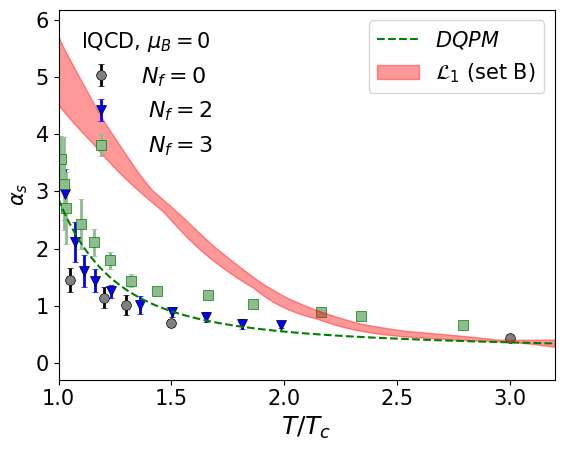

In [26]:
#########comparison
#LATTICE
data_Nf0 = np.loadtxt('..//EoS_data/lQCD_as/alpha_s_gluon_data_lQCD.dat')
data_Nf2 = np.loadtxt('..//EoS_data/lQCD_as/alpha_s_nf2_kazmarek.dat')
data_Nf3 = np.loadtxt('..//EoS_data/lQCD_as/alpha_s_nf3.dat')

xTl_0 = data_Nf0[::,0]
asl_0 = data_Nf0[::,2]
errasl_0 = data_Nf0[::,3]
xTl_2 = data_Nf2[::,0]
asl_2= data_Nf2[::,1]
errasl_2 = data_Nf2[::,3]

xTl_3 = data_Nf3[::,0]
asl_3= data_Nf3[::,1]
errasl_3 = data_Nf3[::,2] - data_Nf3[::,1]

##########
Tmax = 3.2
##########
fig = plt.figure()
ax = fig.add_subplot(111)
mrksize = 7


eval = np.linspace(0.155,Tc*Tmax,200)

g2_max = np.zeros(x_size)
g2_min = 1e8*np.ones(x_size)
for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  g2 = g_nn(eval)**2
  g2_max = np.max([g2_max,g2], axis=0)
  g2_min = np.min([g2_min,g2], axis=0)


xT = eval
g2_DQPM = 4*pi*(0.00602 + 0.22908/xT - 0.0425/xT**2 + 0.00288/xT**3  + 0.00148/xT**4)

g2_DQPM2 = 4*pi*(0.00302 + 0.2408/xT - 0.0405/xT**2 + 0.0042/xT**3  + 0.0018/xT**4)
plt.plot(eval / Tc,g2_DQPM/(4.*pi),'--', color='g',label=r'$DQPM$')
#plt.plot(eval / Tc,g2_DQPM2/(4.*pi),'--', color='y',label=r'$DQPM$')
plt.fill_between(eval/Tc,g2_max/(4.*pi),g2_min/(4.*pi),color="r",label=r'$\mathcal{L}_1$ (set B)',alpha=0.4)
# plt.plot(eval/0.158,g2_light/(4.*pi),'b',label=r'$g^2/(4 \pi)$ from light')

scat1 = plt.errorbar(xTl_0, asl_0, errasl_0, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0)
scat2=plt.errorbar(xTl_2, asl_2, errasl_2,  fmt = 'v', markersize = 7, color = 'blue',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='blue',zorder=0)

scat3=plt.errorbar(xTl_3, asl_3, errasl_3,  fmt = 's', markersize = mrksize, color = 'darkseagreen',
             mec='green', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='darkseagreen',zorder=0)

leg = Legend(ax, [scat1,scat2,scat3], ['$N_f=0$',' $N_f=2$',' $N_f=3$'],
             loc='upper left',ncol =1, frameon=False, fontsize = 16,title='lQCD, $\mu_B=0$')
ax.add_artist(leg)
ax.set_xlabel('$T/T_c(\mu_B)$', fontsize = 18)
#ax.set_ylabel('$\\alpha_s$', fontsize = 20)
plt.vlines(1.0, 0, 3.45,color='grey',  linestyles='dashed',zorder=0)
#plt.xlabel(r'$T[GeV]$')
plt.xlabel(r'$T/T_c$')
plt.ylabel(r'$\alpha_s$')

ax.set_xlim([1, Tmax])
#ax.set_ylim([0.0, 5])
# plt.title(f"fit DNN $\delta M =${dms} GeV")
#plt.savefig(f'./ag_alphas_comparisondeltam{dms}.pdf')
plt.legend()
plt.show()

<ipython-input-13-73a9daca0f19>:35: RuntimeWarning: overflow encountered in exp
  dfa = 1/(np.exp((E-sign*mu)/T)+1)  # Fermi-Dirac
<ipython-input-13-73a9daca0f19>:53: RuntimeWarning: overflow encountered in exp
  etaq = angular_pref*p**2*(1/(2*pi**3)*16/(np.exp(om/(2*T))-np.exp(-om/(2*T)))**2*rhorel(om,p,m,gam)**2*ps + 1/(2*pi**3)*p**4*ffblock*fq)
<ipython-input-13-73a9daca0f19>:53: RuntimeWarning: overflow encountered in double_scalars
  etaq = angular_pref*p**2*(1/(2*pi**3)*16/(np.exp(om/(2*T))-np.exp(-om/(2*T)))**2*rhorel(om,p,m,gam)**2*ps + 1/(2*pi**3)*p**4*ffblock*fq)
<ipython-input-30-5c958071abc9>:76: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  scat += plt.errorbar(data_lat[i][::,0], data_lat[i][::,1], data_lat[i][::,2], fmt=lss[i], color=cls[i], markersize=6,mec='black', mew=0.5, elinewidth=2.0, capsize=2.0,label =labels[i])


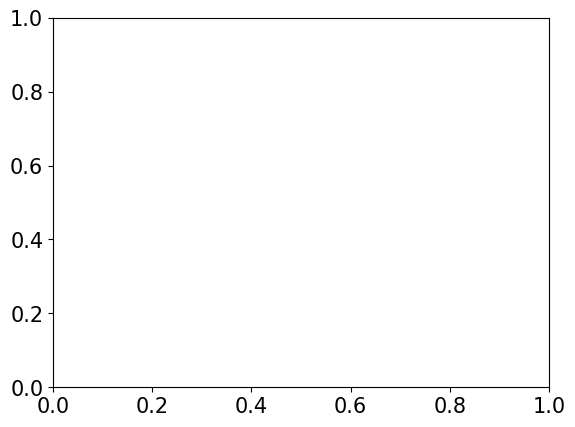

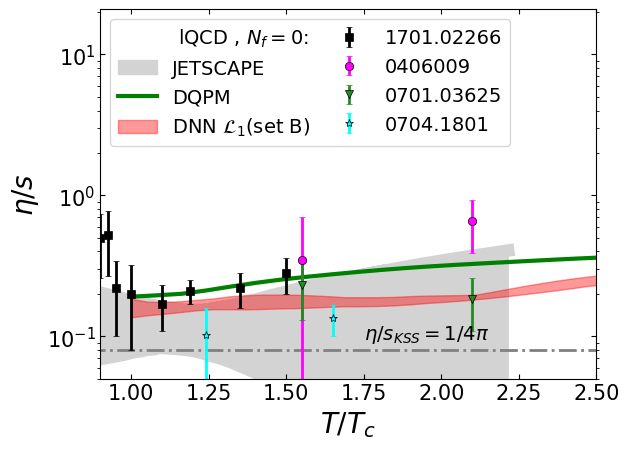

In [30]:

data_0 = np.loadtxt('..//transport_coeff/dqpm_21/gDQPM2021_etas_T_mu0.dat')
data_kubo = np.loadtxt('..//transport_coeff/dqpm_kubo/etas_dqpm_kubo.txt')
data_pnjl = np.loadtxt('..//transport_coeff/pnjl_22/etas_T_muq0_rates.dat')
data_4 = np.loadtxt('..//transport_coeff/dqpm_21/gDQPM2021_etas_T_mu04.dat')
data_ju = np.loadtxt('..//transport_coeff/jetscape/jetscape_eta_s_T_up.dat')
data_jb = np.loadtxt('..//transport_coeff/jetscape/jetscape_eta_s_T_bott.dat')
data_lat =[]
data_lat.append(np.loadtxt('..//transport_coeff/lattice/fig2a_etas_latticeBraguta.dat'))
data_lat.append(np.loadtxt('..//transport_coeff/lattice/etas_2p_0406009.dat'))
data_lat.append(np.loadtxt('..//transport_coeff/lattice/etas_2p_070103625.dat'))
data_lat.append(np.loadtxt('..//transport_coeff/lattice/etas_2p_070418001.dat'))

####################################################
fig = plt.figure()
ax = fig.add_subplot(111)
Lt = 10
lss = ['sk', 'o', 'v', '*']
cls=['black','magenta','forestgreen','cyan']
labels =['1701.02266','0406009','0701.03625','0704.1801']
labels.append('1701.02266')
#####################################################
Tc = 0.158
xT_0 = data_0[::,1]
ypnew_0 = data_0[::,3]

xT_0kubo = data_kubo[::,0]
ypnew_0kubo = data_kubo[::,1]

xT_4 = data_4[::,0]
ypnew_4 = data_4[::,3]

xT_ju = data_ju[::,0]
yj_u = data_ju[::,1]

xT_jb = data_jb[::,0]
yj_jb = data_jb[::,1]

xT_0p = data_pnjl[::,1]/0.2124
ypnew_0p = data_pnjl[::,4]

# T_qp = np.linspace(0.1,0.5,100)
# etakqp = data_qpm[::,1]
size_Tnn = 30
T_nn = np.linspace(0.158,0.4,size_Tnn)

eta_max = np.zeros(size_Tnn)
eta_min = 1e8*np.ones(size_Tnn)
for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  etaknn = [eta_s(T) for T in T_nn]
  eta_max = np.max([eta_max,etaknn], axis=0)
  eta_min = np.min([eta_min,etaknn], axis=0)

##KSS BOUND
xT_ss=np.arange(0.09, 4.0, 0.02)
T_ss = np.linspace(0.11,0.53,100)
etas_kss = lambda T : 0.079577472
y_ss=0.079577472*xT_ss**0
f_t = lambda T: 1.+ 1.2*(T-0.165)/(0.165-0.1)*np.sign(T-0.165)
etas_mus =lambda T: 0.1*f_t(T)
#mu,=plt.plot([], [], ' ',linewidth =2, label=' ')
mu,=plt.plot([], [], ' ',linewidth =2, label=' lQCD , $N_f=0$:')
plt.fill_between(xT_ju/Tc, yj_jb,yj_u, color='lightgrey',label = 'JETSCAPE',zorder =0)
plt.plot(xT_ju/Tc, yj_u, '-', linewidth=9.0, color='lightgrey' ,zorder =1)
plt.plot(xT_jb/Tc, yj_jb, '-', linewidth=9.0, color='lightgrey',zorder =1)
#plt.plot(xT_0, ypnew_0, '-', linewidth=3.0, color='green', label='DQPM(RTA)',zorder =2 )
plt.plot(xT_0kubo, ypnew_0kubo, '-', linewidth=3.0, color='green', label='DQPM',zorder =2 )
plt.plot(xT_ss/Tc, y_ss, '-.', linewidth=2.0, color='grey' )
#plt.plot(T_ss/Tc, etas_mus(T_ss), '--', linewidth=2.0, color='blue' , label='MUSIC')

# plt.plot(T_qp/Tc, etakqp, '--', linewidth=2.0, color='magenta' , label='Kubo QP NN')
plt.fill_between(T_nn/Tc, eta_max,eta_min, color='r' , label='DNN $\mathcal{L}_1$(set B)',alpha=0.4)
scat = []
for i in range (0,4):
    scat += plt.errorbar(data_lat[i][::,0], data_lat[i][::,1], data_lat[i][::,2], fmt=lss[i], color=cls[i], markersize=6,mec='black', mew=0.5, elinewidth=2.0, capsize=2.0,label =labels[i])

#plt.plot(xT_4, ypnew_4, '-', linewidth=3.0, color='orange' )

ax.text(1.75, 0.095, r'$\eta/s_{KSS} =1/4 \pi$', fontsize=14)
ax.set_xlabel('$ T/T_c$', fontsize = 20)
ax.set_ylabel('$\eta /s$', fontsize = 20)
# plt.title(f"fit DNN $\delta M =${dms} GeV")
plt.legend(loc = 'upper left', ncol = 2,
           numpoints = 1, fontsize = 14, columnspacing = 1)#,title =' $\mu_B = 0$'

ax.set_yscale('log')
ax.set_xlim([0.9, 2.50])
ax.set_ylim([0.05,20.95])
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="x", direction="in")
ax.tick_params(axis="y", direction="in")

data_to_save = np.column_stack((T_nn/Tc , eta_max, eta_min))
header = 'T/Tc, eta_max,eta_min'
namefile = f'ag_etas.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter=' ', fmt='%12.5f %12.5f %12.5f', header=header)

# data_to_save = np.column_stack((T_nn/Tc,etaknn ))
header = 'T/Tc, etas/T(full) '
# np.savetxt(f'mass_data_etas_dms{dms}.txt', data_to_save, delimiter='', fmt='%12.5f %12.5f ', header=header)
plt.show()
plt.clf()



<ipython-input-13-73a9daca0f19>:35: RuntimeWarning: overflow encountered in exp
  dfa = 1/(np.exp((E-sign*mu)/T)+1)  # Fermi-Dirac
/usr/local/lib/python3.10/dist-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
<ipython-input-31-9ab65bbe64df>:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  scat += plt.errorbar(data_lat[i][::,0], data_lat[i][::,1], data_lat[i][::,2], fmt=lss[i], color=cls[i], markersize=6,mec='black', mew=0.5, elinewidth=2.0, capsize=2.0,label =labels[i])
<ipython-input-31-9ab65bbe64df>:90: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0.0, 0.1])


<Figure size 640x480 with 0 Axes>

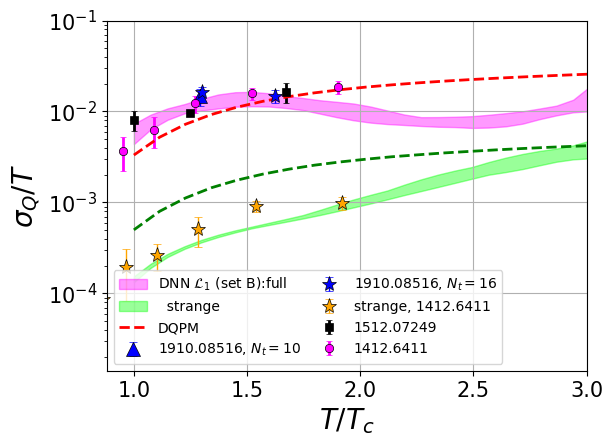

In [31]:
#data 4 comparison
data_old = np.loadtxt('..//transport_coeff/dqpm_rta/conductivity_old_rta_2019.dat')
data_kubo = np.loadtxt('..//transport_coeff/dqpm_kubo/cond_dqpm_kubo.txt')

data_lat =[]
data_lat.append(np.loadtxt('..//transport_coeff/lattice/cond_latt_Nf2.dat'))
data_lat.append(np.loadtxt('..//transport_coeff/lattice/cond_latt_Nf2+1.dat'))
data_strange = (np.loadtxt('..//transport_coeff/lattice/latt_cond_s_T_Nf2+1.dat'))
lss = ['sk', 'o', 'v', '*']
cls=['black','magenta','forestgreen','cyan']
labels =['1512.07249','1412.6411','','']

Tc = 0.158
#format #T	TTc	cond	cond/T	cond	cond/T

xT_old = data_kubo[::,0]
ysigm_old_strange = data_kubo[::,1]
ysigm_old_full = data_kubo[::,2]

#lattice
#T/T_c sigma/T error

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
Lt = 10

size_Tnn = 30
T_nn = np.linspace(0.158,0.5,size_Tnn)

condl_max = np.zeros(size_Tnn)
condl_min = 1e8*np.ones(size_Tnn)
conds_max = np.zeros(size_Tnn)
conds_min = 1e8*np.ones(size_Tnn)
for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  condl = np.array([fcond_light(T) for T in T_nn])
  condl_max = np.max([condl_max,condl], axis=0)
  condl_min = np.min([condl_min,condl], axis=0)

  conds = np.array([fcond_strange(T) for T in T_nn])
  conds_max = np.max([conds_max,conds], axis=0)
  conds_min = np.min([conds_min,conds], axis=0)


Cem = 8/3*pi/137
#cond=1/Cem*condknn
Cems = 4/9*pi/137

# plt.errorbar(np.array([0.8, 1.0, 1.25, 1.67]), [0.074, 0.160, 0.189, 0.323], [0.061, 0.040, 0.010, 0.078],
#              fmt = 'o', markersize = 8, color = 'blue', label = '$N_f=2$ B. Brandt et al, 1512.07249 (2015)',
#              mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='black')

# plt.errorbar(np.array([0.7, 0.75, 0.85, 1.0, 1.15, 1.35, 1.75]), [0.06, 0.0725, 0.06, 0.12, 0.21, 0.26, 0.32], [0.05, 0.025, 0.025, 0.05, 0.05, 0.05, 0.10],
#              fmt = 'd', markersize = 8, color = 'green', label = '$N_f=2+1:$ A. Amato et al, 1307.6763 (2013)',
#              mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='black')

plt.errorbar([200.0 / 155.0], [0.24*Cem], [0.05*Cem],
             fmt = '^', markersize = 10, color = 'blue', label = '1910.08516, $N_t = 10$',
             mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='blue')

plt.errorbar([200.0 / 155.0 + 0.01, 250 / 155.0 + 0.01], [0.268*Cem, 0.243*Cem], [0.036*Cem, 0.041*Cem],
             fmt = '*', markersize = 11, color = 'blue', label = '1910.08516, $N_t = 16$',
             mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='blue')
plt.errorbar(data_strange[::,0], data_strange[::,1]*Cems, data_strange[::,2]*Cems,
             fmt = '*', markersize = 11, color = 'orange', label = 'strange, 1412.6411',
             mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='orange')

scat = []
for i in range (0,2):
    scat += plt.errorbar(data_lat[i][::,0], data_lat[i][::,1], data_lat[i][::,2], fmt=lss[i], color=cls[i], markersize=6,mec='black', mew=0.5, elinewidth=2.0, capsize=2.0,label =labels[i])


#plt.errorbar([200.0 / 155.0 - 0.01, 250 / 155.0 - 0.01], [0.244, 0.225], [0.011,0.028],
#             fmt = '<', markersize = 8, color = 'orange', label = 'this paper, $N_t = 16$',
#             mec='black', mew=0.5, elinewidth=1.0, capsize=3.0, ecolor='black')
plt.fill_between(T_nn/Tc , conds_max + condl_max, conds_min + condl_min, color='magenta', label='DNN $\mathcal{L}_1$ (set B):full', alpha = 0.4)
plt.fill_between(T_nn/Tc , conds_max, conds_min, color='lime' , label='  strange',alpha=0.4)

plt.plot(xT_old, ysigm_old_full, '--', linewidth=2.0, color='red' , label='DQPM')
plt.plot(xT_old, ysigm_old_strange, '--', linewidth=2.0, color='green' )
#plt.title(f"fit DNN $\delta M =${dms} GeV")
plt.gcf().subplots_adjust(bottom = 0.15)
plt.gcf().subplots_adjust(left = 0.15)
plt.legend(loc = 'lower left', ncol = 2, numpoints = 1, fontsize = 10, columnspacing = 1)
ax.set_xlabel('$T / T_c$', fontsize = 20)
ax.set_ylabel('$\\sigma_Q / T$', fontsize = 20)
ax.set_yscale('log')
ax.set_xlim([0.88, 3.0])
ax.set_ylim([0.0, 0.1])
ax.grid(True)
#ax.get_yaxis().set_major_formatter(FormatStrFormatter('%.1f'))
# plt.savefig(f'./ag_sigma_comparisondeltam{dms}.pdf')
data_to_save = np.column_stack((T_nn/Tc , conds_max, conds_min, conds_max + condl_max, conds_min + condl_min ))
header = 'T/Tc, sigma/T(strange)_max,sigma/T(strange)_min, sigma/T(full)_max, sigma/T(full)_min'
namefile = f'ag_sigmaT.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f %12.5f %12.5f', header=header)
plt.show()
plt.clf()

THERMODYNAMIC FUNCTIONS

<ipython-input-27-4796674fae0e>:54: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  ds = scipy.misc.derivative(sentr,T,dT,order=3)


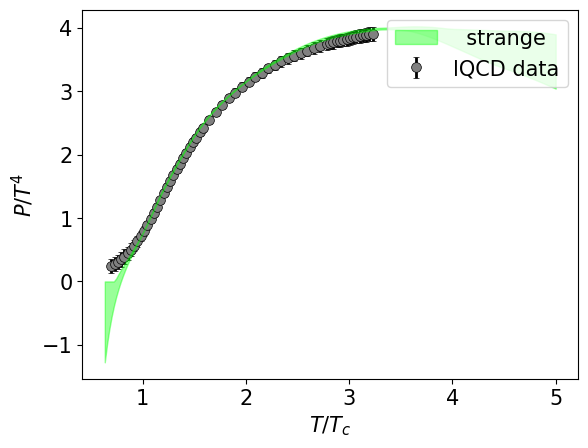

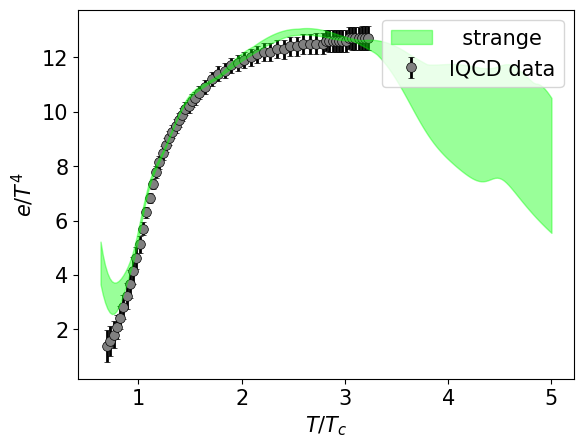

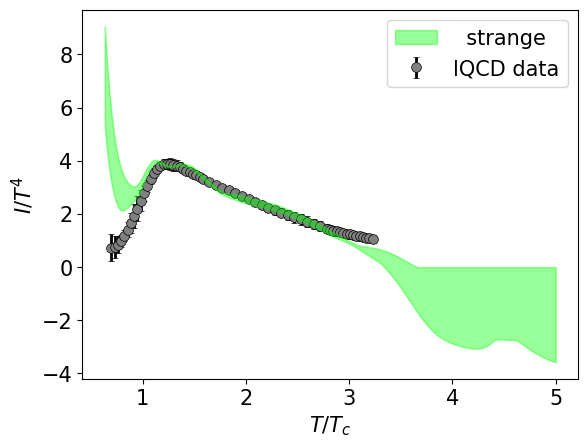

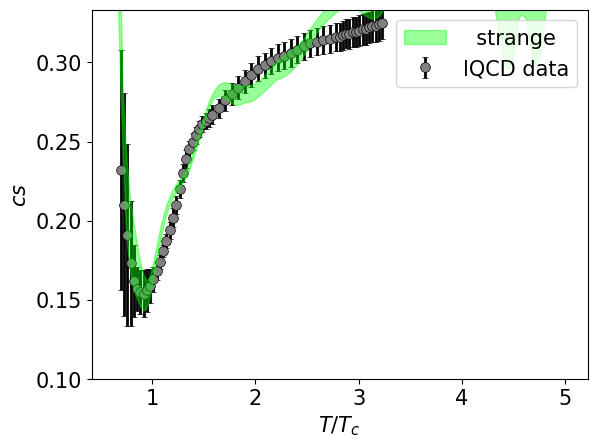

In [27]:
##THESE ARE THE SAME AS THE ONE USED TO PLOT s, chi_bs
# x_size = 200
# Tc=0.158
# Tmax = 3.2
# Temp_values = np.linspace(0.155, Tc*Tmax, x_size)
# Temp_tensor = tf.constant(Temp_values, dtype=tf.float32)



Temp_values = np.linspace(0.1, 5*Tc, x_size)
Temp_tensor = tf.constant(Temp_values, dtype=tf.float32)



## thermodynamics
def s(T,f_interpolated):
  s = f_interpolated(T)*T**3
  return np.array(s)#entropy_T3(temp).numpy()[0]*T**3

def s_(T):
  temp = tf.constant(np.array([T]),dtype=tf.float32)
  return entropy_T3(temp).numpy()[0]*T**3

def pres(T,f):
  P0 = 0.00047569             # p_T4[TchiS==0.158]*0.158**4
  T0 = 0.158
  P = P0 + scipy.integrate.quad(s,T0,T,args=f,limit=100)[0]
  return P

def fast_pressure(T,f): ##COMPUTE THE PRESSURE FROM A LIST OF TEMPERATURES and returns a list
  P0 = 0.00047569             # p_T4[TchiS==0.158]*0.158**4
  Tprev = 0.158
  pressure_list = []
  Pprev = P0
  for i in range(len(T)):
    Tsuc = T[i]
    Psuc = Pprev + scipy.integrate.quad(s,Tprev,Tsuc,args=f,limit=100)[0]
    pressure_list.append(Psuc)
    Tprev = Tsuc
    Pprev = Psuc
  return np.array(pressure_list)


def energy(Temp_list,entropyT3_list,P_list):
  return np.array((Temp_list**4) *entropyT3_list-P_list)

def I(energy_list,P_list):
  I = energy_list-3*P_list
  return I

def sound_speed(T,dT,f):
  def sentr(T):
    return s(T,f)
  ds = scipy.misc.derivative(sentr,T,dT,order=3)
  cS = sentr(T)/(T*ds)
  return cS

# def cs(T,f):
#   dT = 0.04
#   s1 = f(T+dT/2)*(T+dT/2)**3
#   s0 = f(T-dT/2)*(T-dT/2)**3
#   ds = (s1-s0)/dT

#   cS = f(T)*(T)**3/(T*ds)

#   return cS


energy_max = np.zeros(x_size)
P_max = np.zeros(x_size)
cs_max = np.zeros(x_size)
I_max = np.zeros(x_size)
I_min = 1e8*np.ones(x_size)
energy_min = 1e8*np.ones(x_size)
P_min = 1e8*np.ones(x_size)
cs_min = 1e8*np.ones(x_size)


for i in models:
  quasiparticle = tf.keras.models.load_model(i,custom_objects={"Lambda" : custom_activation})

  entropy_fit = entropy_T3(Temp_tensor).numpy()
  test_temp = tf.constant(np.linspace(0.01,10*Tc,10000),dtype=tf.float32)
  f = scipy.interpolate.interp1d(test_temp.numpy(),entropy_T3(test_temp).numpy(),kind="cubic")

  P_fit = fast_pressure(Temp_tensor.numpy(),f)
  energy_fit = energy(Temp_tensor.numpy(),entropy_fit,P_fit)
  I_fit = I(energy_fit,P_fit)
  cs_fit = [sound_speed(Temp,0.02,f) for Temp in Temp_tensor]

  energy_max = np.max([energy_max,energy_fit], axis=0)
  P_max = np.max([P_max,P_fit], axis=0)
  cs_max = np.max([cs_max,cs_fit], axis=0)
  I_max = np.max([I_max,I_fit], axis=0)

  energy_min = np.min([energy_min,energy_fit], axis=0)
  P_min = np.min([P_min,P_fit], axis=0)
  cs_min = np.min([cs_min,cs_fit], axis=0)
  I_min = np.min([I_min,I_fit], axis=0)

data_to_save = np.column_stack((Temp_values/Tc , energy_max/Temp_values**4, energy_min ))
header = 'T/Tc, energy/T^4_max,energy/T^4_min'
namefile = f'ag_energyT4.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f', header=header)

data_to_save = np.column_stack((Temp_values/Tc , P_max/Temp_values**4, P_min/Temp_values**4 ))
header = 'T/Tc, P/T^4_max,P/T^4_min'
namefile = f'ag_PressureT4.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f', header=header)

data_to_save = np.column_stack((Temp_values/Tc , I_max/Temp_values**4, I_min/Temp_values**4 ))
header = 'T/Tc, I/T^4_max,I/T^4_min'
namefile = f'ag_IT4.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f', header=header)

data_to_save = np.column_stack((Temp_values/Tc , cs_max, cs_min ))
header = 'T/Tc, cs_max,cs_min'
namefile = f'ag_sound_speed.txt'
namefile = dir_seeds + namefile
np.savetxt(namefile, data_to_save, delimiter='', fmt='%12.5f %12.5f %12.5f', header=header)

plt.figure(1)
plt.fill_between(Temp_values/Tc , P_max/Temp_values**4, P_min/Temp_values**4, color='lime' , label='  strange',alpha=0.4)
plt.errorbar(Tentr/Tc,P_T4,yerr=DP_T4, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$P/T^4$")
# plt.xlim([0.9, Tmax])
plt.legend()
plt.figure(2)
plt.fill_between(Temp_values/Tc , energy_max/Temp_values**4, energy_min/Temp_values**4, color='lime' , label='  strange',alpha=0.4)
plt.errorbar(Tentr/Tc,e_T4,yerr=De_T4, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$e/T^4$")
# plt.xlim([0.9, Tmax])
plt.legend()
plt.figure(3)
plt.fill_between(Temp_values/Tc , I_max/Temp_values**4, I_min/Temp_values**4, color='lime' , label='  strange',alpha=0.4)
plt.errorbar(Tentr/Tc,I_T4,yerr=DI_T4, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$I/T^4$")
# plt.xlim([0.9, Tmax])
plt.legend()
plt.figure(4)
plt.fill_between(Temp_values/Tc , cs_max, cs_min, color='lime' , label='  strange',alpha=0.4)
plt.errorbar(Tentr/Tc,csdata,yerr=Dcs, fmt = 'o', markersize = 7, color = 'grey',
             mec='black', mew=0.5, elinewidth=2.0, capsize=2.0, ecolor='black',zorder=0,label= "lQCD data")
plt.xlabel(r"$T/T_c$")
plt.ylabel(r"$cs$")
# plt.xlim([0.9, Tmax])
plt.ylim([0.1,1/3])
plt.legend()
plt.show()
